## Initialization 

In [124]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import geom, kstest
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import time
np.random.seed(1234)

## 1) Geometric Distribution

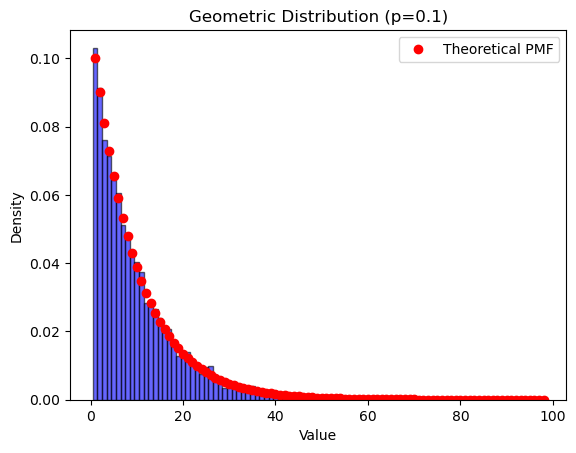

K-S test for geometric distribution with p=0.1: D = 0.1000, p-value = 0.0000


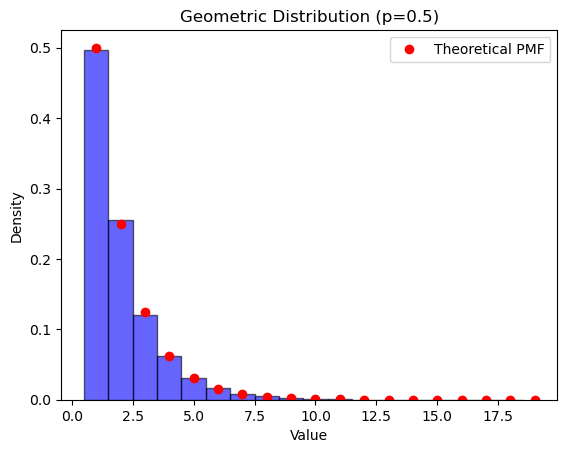

K-S test for geometric distribution with p=0.5: D = 0.5000, p-value = 0.0000


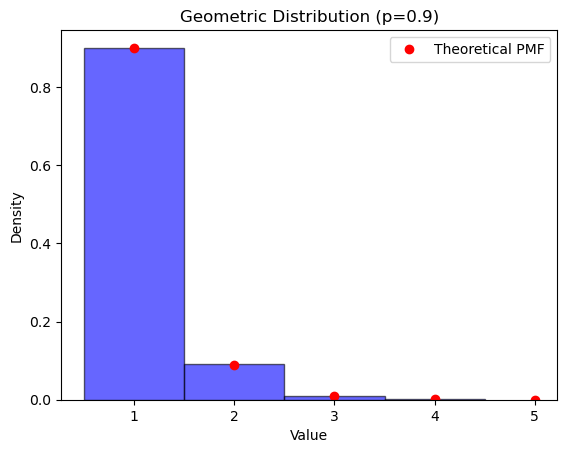

K-S test for geometric distribution with p=0.9: D = 0.9000, p-value = 0.0000


In [125]:
# Set parameters for the geometric distribution
p_values = [0.1, 0.5, 0.9]
n_samples = 10000

# Function to generate and compare samples
def simulate_and_compare(p):
    # Generate samples
    geometric_samples = np.random.geometric(p, n_samples)
    
    # Plot histogram
    plt.hist(geometric_samples, bins=np.arange(1, max(geometric_samples) + 1) - 0.5, density=True, alpha=0.6, color='b', edgecolor='black')
    
    # Plot theoretical PMF
    x = np.arange(1, max(geometric_samples) + 1)
    pmf = geom.pmf(x, p)
    plt.plot(x, pmf, 'ro', label='Theoretical PMF')
    
    plt.title(f'Geometric Distribution (p={p})')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()
    

    # Perform K-S test
    d_statistic, p_value = kstest(geometric_samples, 'geom', args=(p,))
    print(f"K-S test for geometric distribution with p={p}: D = {d_statistic:.4f}, p-value = {p_value:.4f}")

# Simulate and compare for each p value
for p in p_values:
    simulate_and_compare(p)

## 2) 6-Point Distribution

In [126]:
# Define the discrete distribution
values = np.array([1, 2, 3, 4, 5, 6])
probabilities = np.array([7/48, 5/48, 1/8, 1/16, 1/4, 5/16])

## Direct Method

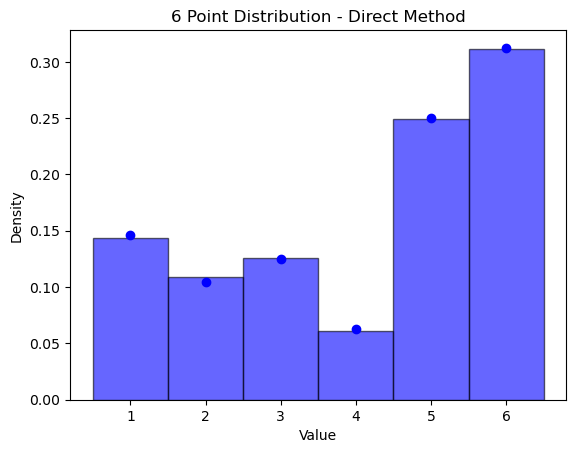

In [127]:
# Starts a timer for computing the crude samples
time_start = time.time()

# Create the CDF
cdf = np.cumsum(probabilities)

# Number of samples
n_samples = 10000

# Generate uniform random variables
uniform_samples = np.random.uniform(0, 1, n_samples)

# Transform uniform samples using the CDF
direct_samples = values[np.searchsorted(cdf, uniform_samples)]

# Time it takes to compute the crude samples
direct_time = time.time() - time_start

# Plot histogram
plt.hist(direct_samples, bins=np.arange(1, 8) - 0.5, density=True, alpha=0.6, color='b', edgecolor='black')
plt.xticks(values)
plt.plot(values,probabilities,'bo')
plt.title('6 Point Distribution - Direct Method')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

## Rejection Method

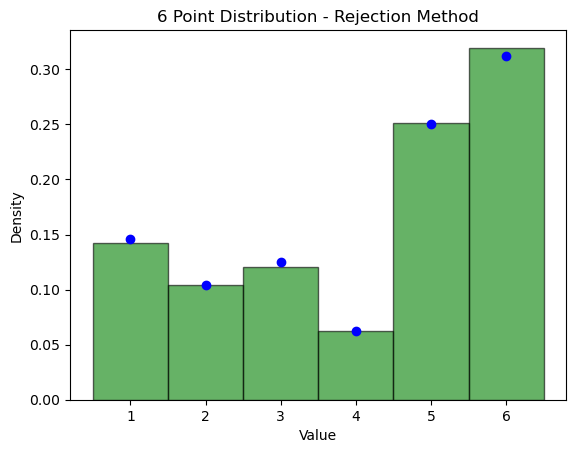

In [128]:
# Starts a timer for computing the rejection samples
start_time = time.time()

# Maximum probability for scaling in rejection method
p_max = max(probabilities)

# Generate samples using the rejection method
rejection_samples = []
while len(rejection_samples) < n_samples:
    u = np.random.uniform(0, 1)
    x = np.random.choice(values)
    if u < probabilities[x-1] / p_max:
        rejection_samples.append(x)

# Rejection samples
rejection_samples = np.array(rejection_samples)

# Time it takes to compute the rejection samples
rejection_time = time.time() - start_time

# Plot histogram
plt.hist(rejection_samples, bins=np.arange(1, 8) - 0.5, density=True, alpha=0.6, color='g', edgecolor='black')
plt.xticks(values)
plt.plot(values,probabilities,'bo')
plt.title('6 Point Distribution - Rejection Method')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

## Alias Method

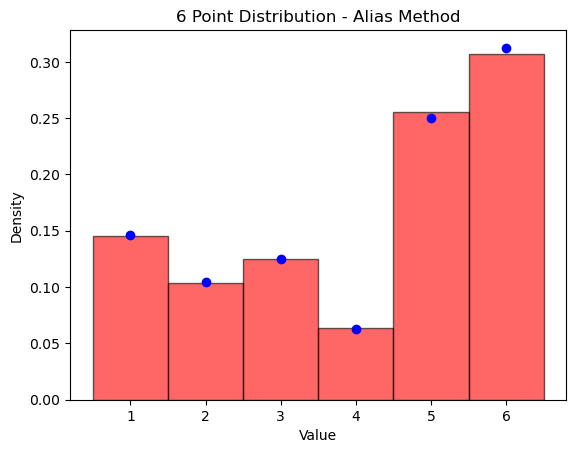

In [129]:
# Starts a timer for computing the alias samples
time_start = time.time()

def create_alias_table(probabilities):
    n = len(probabilities)
    scaled_probs = np.array(probabilities) * n
    alias = np.zeros(n, dtype=int)
    prob = np.zeros(n)
    small = []
    large = []
    
    for i, p in enumerate(scaled_probs):
        if p < 1:
            small.append(i)
        else:
            large.append(i)
    
    while small and large:
        l = small.pop()
        g = large.pop()
        prob[l] = scaled_probs[l]
        alias[l] = g
        scaled_probs[g] = scaled_probs[g] - (1 - scaled_probs[l])
        if scaled_probs[g] < 1:
            small.append(g)
        else:
            large.append(g)
    
    while large:
        g = large.pop()
        prob[g] = 1
    while small:
        l = small.pop()
        prob[l] = 1
    
    return prob, alias

# Create alias tables
prob, alias = create_alias_table(probabilities)

# Generate samples using the Alias method
alias_samples = []
for _ in range(n_samples):
    i = np.random.randint(0, len(probabilities))
    u = np.random.uniform(0, 1)
    if u < prob[i]:
        alias_samples.append(values[i])
    else:
        alias_samples.append(values[alias[i]])

# Alias samples
alias_samples = np.array(alias_samples)

# Time it takes to compute the alias samples
alias_time = time.time() - time_start

# Plot histogram
plt.hist(alias_samples, bins=np.arange(1, 8) - 0.5, density=True, alpha=0.6, color='r', edgecolor='black')
plt.xticks(values)
plt.plot(values,probabilities,'bo')
plt.title('6 Point Distribution - Alias Method')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

## 3) Comparing the three methods

In [130]:
# Function to plot histogram and calculate chi-square statistic
def comparer(samples, expected_prob):
    alpha = 0.05  # Significance level
    observed_counts = np.bincount(samples)[1:]
    n_samples = len(samples)
    expected_counts = expected_prob * n_samples
    df = len(expected_prob) - 1  # Degrees of freedom
    chi2_stat = np.sum((observed_counts - expected_counts)**2 / expected_counts)
    p_value = 1 - stats.chi2.cdf(chi2_stat, df)
    critical_value = stats.chi2.ppf(1 - alpha, df)
    return chi2_stat, p_value, critical_value

direct_chi2 , direct_p_value, direct_critical_value = comparer(direct_samples, probabilities)
rejection_chi2, rejection_p_value, rejection_critical_value = comparer(rejection_samples, probabilities)
alias_chi2, alias_p_value, alias_critical_value = comparer(alias_samples, probabilities)

# Print comparison results
print(f"Method\t\tTime (s)\tChi-Square Statistic\tp-Value\t\tCritical Value")
print(f"Direct\t\t{direct_time:.4f}\t\t{direct_chi2:.4f}\t\t\t{direct_p_value:.4f}\t\t{direct_critical_value:.4f}")
print(f"Rejection\t{rejection_time:.4f}\t\t{rejection_chi2:.4f}\t\t\t{rejection_p_value:.4f}\t\t{rejection_critical_value:.4f}")
print(f"Alias\t\t{alias_time:.4f}\t\t{alias_chi2:.4f}\t\t\t{alias_p_value:.4f}\t\t{rejection_critical_value:.4f}")

Method		Time (s)	Chi-Square Statistic	p-Value		Critical Value
Direct		0.0000		3.4494			0.6311		11.0705
Rejection	0.2717		4.1461			0.5286		11.0705
Alias		0.0569		2.3012			0.8061		11.0705
